# 12a Flame sensor analysis

This notebook forms part of a series on [computational optical radiometry](https://github.com/NelisW/ComputationalRadiometry#computational-optical-radiometry-with-pyradi).  The notebooks can be downloaded from [Github](https://github.com/NelisW/ComputationalRadiometry#computational-optical-radiometry-with-pyradi). These notebooks are constantly revised and updated, please revisit from time to time.  


[<img src="https://zenodo.org/badge/doi/10.5281/zenodo.9910.png"   align="left"/>](http://dx.doi.org/10.5281/zenodo.9910)


The date of this document and module versions used in this document are given at the end of the file.  
Feedback is appreciated: neliswillers at gmail dot com.

## Overview

This notebook provides a simple worked example of a small sensor observing a flame
on a smokestack. 
The objective is to calculate the signal of a simple infrared sensor, detecting the
presence or absence of a flame in the sensor field of view. The sensor is
pointed to an area just outside a furnace vent, against a clear sky
background. The sensor must detect a change in signal indicating the presence
of a flame at the vent.  

This problem is taken from [my book](http://spie.org/Publications/Book/2021423?origin_id=x646), Chapter 9.

In [1]:
from IPython.display import display
from IPython.display import Image
from IPython.display import HTML

The system has the elements in the following picture:

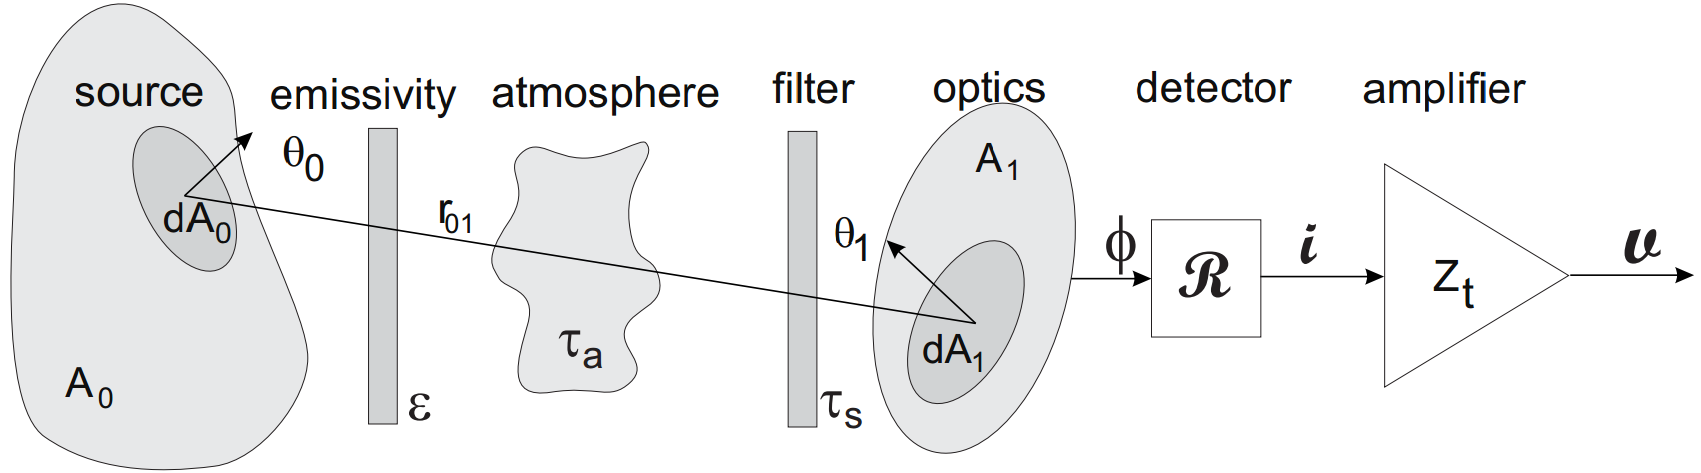

In [2]:
display(Image(filename='images/sensorsystem.png'))

The sensor has an aperture area of 7.8e-3 m$^2$ and a field of view of 1e-4 sr.
The InSb or PbSe detector has a peak responsivity of 2.5 A/W and spectral
response The preamplifier transimpedance is 10000 V/A.
The sensor filter spectral transmittance is  calculated with [`pyradi.ryutils.sfilter`](http://nelisw.github.io/pyradi-docs/_build/html/ryutils.html#pyradi.ryutils.sfilter) and parameters  $\tau_s = 0.0001$, $\tau_p = 0.9$, $s = 12$, $\Delta\lambda = 0.8$ $\mu$m, $\lambda_c = 4.3 \mu$m.


The flame area is 1 m$^2$, the flame temperature is 1000 C. The emissivity is
0.1 over most of the spectral band, due to carbon particles in the flame. At
4.3 $\mu$m there is a strong emissivity rise due to the hot CO$_2$ in the flame.
The emissivity can be calculated with [`pyradi.ryutils.sfilter`](http://nelisw.github.io/pyradi-docs/_build/html/ryutils.html#pyradi.ryutils.sfilter) and  parameters  $\tau_s = 0.1$, $\tau_p = 0.7$, $s = 6$, $\Delta\lambda = 0.45 \mu$m, $\lambda_c = 4.33 \mu$m.

The distance between the flame and the sensor is 1000 m. We use the  Modtran
Tropical climatic model. The path is oriented such that the sensor stares out to space,
at a zenith angle of 88.8 deg

The peak in the flame emissivity and the dip in atmospheric transmittance are
both centered around the 4.3 $\mu$m CO$_2$ band. In order to determine the flux
transferred one must perform a spectral calculation taking these strong
spectral variations into account.
From (Eq 6.16), the signal caused by the atmospheric path radiance is given by
\begin{equation}
v_{\rm path}=
\widehat{{ R}}\, Z_t \,A_{1} \, \Omega\,
\int_{0}^{\infty}
 L_{{\rm path}\lambda}
 { S}_{\lambda}
d\lambda,
\end{equation}
where 
$\widehat{{ R}}$ is the peak detector responsivity, 
$Z_t$ is the proximity electronics (preamplifier) gain, 
$A_{1}$ the area of the sensor aperture, 
$\Omega$ is the detector solid angle field of view,
$L_{{\rm path}}$ is the path radiance, 
${ S}=\widetilde{{ R}_\lambda} \tau_{f\lambda}$,
$\widetilde{{ R}_\lambda}$ is the normalised detector response, and 
$\tau_{f\lambda}$ is the atmospheric transmittance.  Note that the path radiance term does not have an atmospheric transmittance factor because the radiance is the net effect of the atmosphere see (Eq 4.10).


The signal when the flame is present is given by
\begin{equation}
v_{\rm flame}=
\widehat{{ R}}\, Z_t \,A_{1} \left[
\left(\frac{A_{0} }{R_{01}^2}\right)\,
\int_{0}^{\infty}
 \epsilon_{0\lambda} L_{0\lambda}
\,\tau_{a\lambda} { S}_\lambda 
d\lambda
+
\left(\Omega -  \frac{A_{0} }{R_{01}^2}  \right)\,
\int_{0}^{\infty}
 L_{{\rm path}\lambda}
 { S}_{\lambda}
d\lambda
\right],
\end{equation}
where 
$A_{0}$ is the flame area because  $\cos\theta_0=1$, and
$R_{01}^2$ is the distance between the flame and the sensor.
Note that the flame only fills a small portion of the field of view and the rest is filled by sky path radiance.

It is convenient to define the sensor field of view fill factor as $f=\Omega_T/\Omega_P$ where $\Omega_T$ is the target solid angle and $\Omega_P$ is the sensor pixel field of view.  If the target solid angle total fills or exceeds the pixel field of view, the fill factor is unity.  If the target solid angle is smaller than the pixel field of view solid angle the fill factor is smaller than unity.


In [3]:
%matplotlib inline
import numpy as np
import pyradi.ryfiles as ryfiles
import pyradi.ryplot as ryplot
import pyradi.ryplanck as ryplanck
import pyradi.ryutils as ryutils

Create the spectral range to be used for the calculation. Create the range in wavenumber domain and immediately create a corresponding wavelength domain. These points correspond value by value, so they can be used interchangeably in conversions and plotting.  Use [`pyradi.ryutils.convertSpectralDomain`](http://nelisw.github.io/pyradi-docs/_build/html/ryutils.html#pyradi.ryutils.convertSpectralDomain) for this purpose.

In [4]:
waven = np.arange(2000.0,  3300.0,  2.5).reshape(-1, 1)
wavel= ryutils.convertSpectralDomain(waven,  type='nl')

Read the input data files.  The relevant files are all gzipped up and available for download from the [pyradi website](https://github.com/NelisW/pyradi/tree/master/pyradi/data).  Use the [`ryfiles.downloadUntar`](http://nelisw.github.io/pyradi-docs/_build/html/ryfiles.html#pyradi.ryfiles.downloadUntar) function in ryfiles to do the download and unzipping to a local directory in one single function call.

In [5]:
tgzFilename = 'flamesensordata.tgz'
destinationDir = '.'
tarFilename = 'flamesensordata.tar'
url = 'https://raw.githubusercontent.com/NelisW/pyradi/master/pyradi/data/'
dlNames = ryfiles.downloadUntar(tgzFilename, url, destinationDir, tarFilename)

print('filesAvailable is {}'.format(dlNames))

filesAvailable is ['detectorflamesensor.txt', 'path1kmflamesensor.txt', 'pathspaceflamesensor.txt']


Load atmospheric transmittance from  a tape7 file created with Modtran.  The transmittance is in column 1, and the path radiance is in column 9.    The Modtran data is in wavenumber spectral domain with
5 cm$^{-1}$ intervals, but we want to work in wavelength with 2.5 cm$^{-1}$ resolution.  The interpolation is performed as part of the file reading process using [`ryfiles.loadColumnTextFile`](http://nelisw.github.io/pyradi-docs/_build/html/ryfiles.html#pyradi.ryfiles.loadColumnTextFile).  Modtran calculates path radiance in units of W/(cm$^2$.sr.cm$^{-1}$), but it is required in units of W/(m$^2$.sr.$^{-1}$) - the conversion is done while reading the data from the file.

In [6]:
tauA = ryfiles.loadColumnTextFile('./path1kmflamesensor.txt',
    [1], abscissaOut=waven, comment='%')
lpathwn = ryfiles.loadColumnTextFile('./pathspaceflamesensor.txt',
    [9], abscissaOut=waven, ordinateScale=1.0e4, comment='%')

Convert path radiance spectral density from 1/cm$^{-1}$ to 1/$\mu$m, at the sample wavenumber points.
Use the function [`pyradi.ryutils.convertSpectralDensity`](http://nelisw.github.io/pyradi-docs/_build/html/ryutils.html#pyradi.ryutils.convertSpectralDensity) for this purpose.

In [7]:
(dum, lpathwl) = ryutils.convertSpectralDensity(waven, lpathwn, type='nl')

Load the detector file in wavelengths, and interpolate to  required spectral domain values.

In [8]:
detR = ryfiles.loadColumnTextFile('./detectorflamesensor.txt',
    [1], abscissaOut=wavel, comment='%')

Construct the flame emissivity from parameters, using the [`pyradi.ryutils.sfilter`](http://nelisw.github.io/pyradi-docs/_build/html/ryutils.html#pyradi.ryutils.sfilter) function. Normally one would use measured emissivity data.

In [9]:
emis = ryutils.sfilter(wavel,center=4.33, width=0.45, exponent=6, taupass=0.8,
    taustop=0.1 )

Construct the filter spectral transmittance from parameters, using the [`pyradi.ryutils.sfilter`](http://nelisw.github.io/pyradi-docs/_build/html/ryutils.html#pyradi.ryutils.sfilter) function. Normally one would use measured filter data.

In [10]:
#construct the sensor filter from parameters
sfilter = ryutils.sfilter(wavel,center=4.3, width=0.8, exponent=12,
           taupass=0.9, taustop=0.0001)

Plot the data read in and calculated above.  The visual inspection is a critical tool in validating the calculations.

In this particular instance observe how closely the path radiance matches the blackbody radiance at the same temperature. From this simple observation we can conclude that the atmospheric path emissivity is near unity.

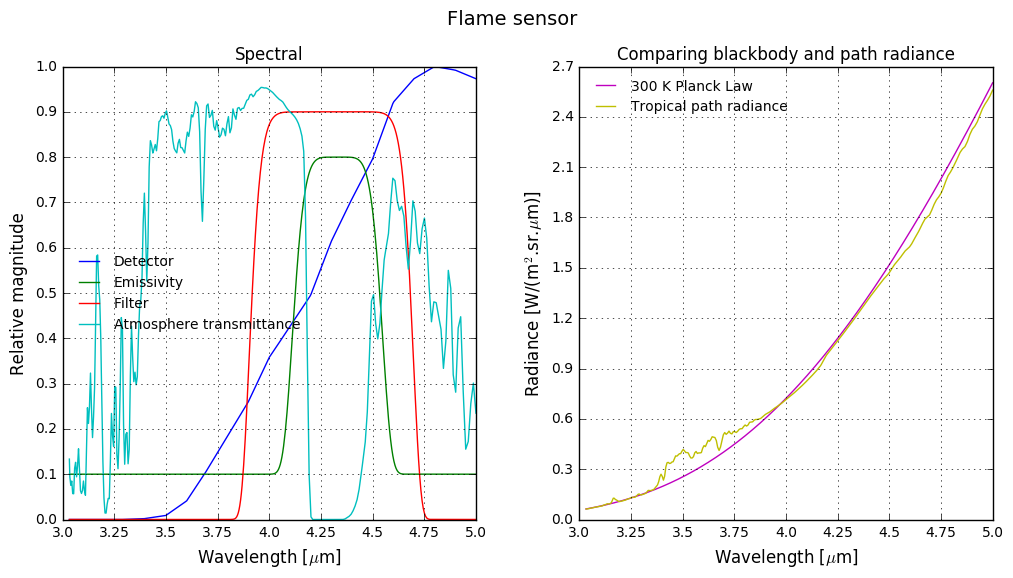

In [11]:
plotdata = detR
plotdata = np.hstack((plotdata,emis))
plotdata = np.hstack((plotdata,sfilter))
plotdata = np.hstack((plotdata,tauA))
label = ['Detector','Emissivity','Filter','Atmosphere transmittance']
plot1= ryplot.Plotter(1, 1, 2,'Flame sensor',figsize=(12,6))
plot1.plot(1, wavel, plotdata, "Spectral","Wavelength [$\mu$m]",
    "Relative magnitude",
    label=label, maxNX=10, maxNY=10)

LbbTropical = ryplanck.planck(wavel, 273+27, type='el').reshape(-1, 1)/np.pi

plotdata = LbbTropical
plotdata = np.hstack((plotdata,lpathwl))

label2=['300 K Planck Law','Tropical path radiance']
plot1.plot(2, wavel, plotdata, 'Comparing blackbody and path radiance', 
           'Wavelength [$\mu$m]','Radiance [W/(m$^2$.sr.$\mu$m)]', label=label2)

The signal when the flame is present is given by
\begin{equation}
v_{\rm flame}=
\widehat{{ R}}\, Z_t \,A_{1} \left[
\left(\frac{A_{0} }{R_{01}^2}\right)\,
\int_{0}^{\infty}
 \epsilon_{0\lambda} L_{0\lambda}
\,\tau_{a\lambda} { S}_\lambda 
d\lambda
+
\left(\Omega -  \frac{A_{0} }{R_{01}^2}  \right)\,
\int_{0}^{\infty}
 L_{{\rm path}\lambda}
 { S}_{\lambda}
d\lambda
\right],
\end{equation}
where 
$A_{0}$ is the flame area because  $\cos\theta_0=1$, and
$R_{01}^2$ is the distance between the flame and the sensor.
Note that the flame only fills a small portion of the field of view and the rest is filled by sky path radiance.

Define sensor scalar parameters.

In [12]:
opticsArea = 7.8e-3 # optical aperture area [m2]
opticsFOV = 1.0e-4 # sensor field of view [sr]
transZ = 1.0e4 # amplifier transimpedance gain [V/A]
responsivity= 2.5 # detector peak responsivity =A/W]

Define the  flame properties.


Define the fill factor as the portion of the field of view that is filled by the flame, then the portion fill by background radiance is (1-fill).  The fill fraction is calculated as the solid angle filled by the flame divided by the solid angle of the field of view.

In [13]:
flameTemperature = 1000.0 + 273.16    # temperature in [K]
flameArea = 1.  # in [m2]
distance = 1000.  # [m]
fill = (flameArea / distance ** 2) /  opticsFOV # how much of FOV is filled
fill = 1 if fill > 1 else fill # limit target solid angle to sensor FOV

Calculate the path radiance signal (absence of the flame). First multiply out the spectral components  - this can be done because all variables are on a common spectral sampling. Then sum the integration by using the `numpy.trapz` function. Finally multiply the integral with the sensor parameters to determine the output signal.

In [14]:
inbandirradiancePath =  lpathwn * detR * sfilter * opticsFOV
totalirradiancePath = np.trapz(inbandirradiancePath.reshape(-1, 1),waven, axis=0)[0]
signalPath = totalirradiancePath * transZ * responsivity * opticsArea

Calculate the  signal with the flame in the field of view. In this case there is both path radiance and flame radiance in the field of view; the two must be added together.  

The flame radiance is calculated by using Planck's law and multiplying with the spectral emissivity. The spectral calculation of the flame signal proceeds similarly to the calculation of the spectral background radiance. The flame signal is then determined by integrating over all wavelengths and then multiplying with the sensor parameters.


The signals from the background and flame are then added together, using the fill factor to determine the fraction contributed by the background.

In [15]:
# get spectral radiance in  W/m^2.sr.cm-1
radianceFlame = ryplanck.planck(waven, flameTemperature,  type='en')\
    .reshape(-1, 1)/np.pi
inbandirradianceFlame = radianceFlame * detR * tauA * emis * sfilter *\
    fill * opticsFOV
totalirradianceFlame = np.trapz(inbandirradianceFlame.reshape(-1, 1),
    waven, axis=0)[0]
totalirradiancePathremainder = totalirradiancePath * (1-fill)
signalFlameOnly = totalirradianceFlame *transZ*responsivity *opticsArea
signalFlame = (totalirradianceFlame + totalirradiancePathremainder ) *\
    transZ*responsivity *opticsArea

Print out the results

Optics    : area=0.0078 m^2 FOV=0.0001 [sr]
Amplifier : gain=10000.0 [V/A]
Detector  : peak responsivity=2.5 [A/W]
Flame     : temperature=1273.16 [K] area=1.0 [m^2] distance=1000.0 [m]
          : fill=0.01 [-]
Flame only: irradiance= 3.29e-04 [W/m^2] signal= 0.0641 [V]
Path      : irradiance= 5.45e-05 [W/m^2] signal= 0.0106 [V]
Flame+Path: irradiance= 3.83e-04 [W/m^2] signal= 0.0746 [V]


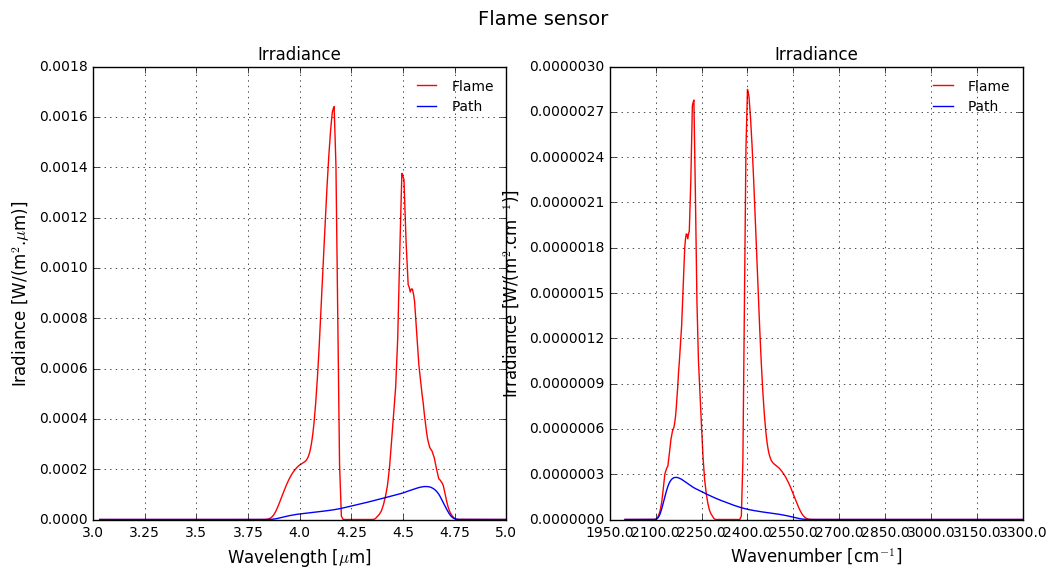

In [16]:
print('Optics    : area={0} m^2 FOV={1} [sr]'.format(opticsArea, opticsFOV ))
print('Amplifier : gain={0} [V/A]'.format(transZ))
print('Detector  : peak responsivity={0} [A/W]'.format(responsivity))
print('Flame     : temperature={0} [K] area={1} [m^2] distance={2} [m]'.\
    format(flameTemperature, flameArea, distance))
print('          : fill={0} [-]'.format(fill))
print('Flame only: irradiance={0:9.2e} [W/m^2] signal={1:7.4f} [V]'.\
    format(totalirradianceFlame, signalFlameOnly))
print('Path      : irradiance={0:9.2e} [W/m^2] signal={1:7.4f} [V]'.\
    format(totalirradiancePath, signalPath))
print('Flame+Path: irradiance={0:9.2e} [W/m^2] signal={1:7.4f} [V]'.\
    format(totalirradianceFlame + totalirradiancePathremainder , \
        signalFlame))

(dum, iFlamewl) = ryutils.convertSpectralDensity(waven,  inbandirradianceFlame, type='nl')
(dum, iPathwl) = ryutils.convertSpectralDensity(waven,  inbandirradiancePath, type='nl')
plot1= ryplot.Plotter(1, 1, 2,'Flame sensor',figsize=(12,6))
plot1.plot(1, wavel, iFlamewl, "Irradiance","Wavelength [$\mu$m]",
    "Iradiance [W/(m$^2$.$\mu$m)]",plotCol=['r'], label=['Flame'])
plot1.plot(1, wavel, iPathwl, "Irradiance","Wavelength [$\mu$m]",
    "Iradiance [W/(m$^2$.$\mu$m)]",plotCol=['b'], label=['Path'])
plot1.plot(2, waven, inbandirradianceFlame, "Irradiance","Wavenumber [cm$^{-1}$]",
    "Irradiance [W/(m$^2$.cm$^{-1}$)]",plotCol=['r'], label=['Flame'])
plot1.plot(2, waven, inbandirradiancePath, "Irradiance","Wavenumber [cm$^{-1}$]",
    "Irradiance [W/(m$^2$.cm$^{-1}$)]",plotCol=['b'], label=['Path'], maxNX=10, maxNY=10)


It is clear that the flame signal is several times larger than the path radiance
signal, even though the flame only fills 1% of the sensor FOV. The
severity by which the atmosphere attenuates the CO$_2$ exitance from the
flame is shown above. Note the path radiance is much smaller than the flame radiance.

# Python and [module versions, and dates](https://github.com/jrjohansson/scientific-python-lectures/blob/master/Lecture-0-Scientific-Computing-with-Python.ipynb)

In [17]:
# you only need to do this once
#!pip install --upgrade version_information

%load_ext version_information
%version_information numpy, scipy, matplotlib, pyradi

Software versions
Python 2.7.12 64bit [MSC v.1500 64 bit (AMD64)]
IPython 5.1.0
OS Windows 7 6.1.7601 SP1
numpy 1.11.1
scipy 0.18.1
matplotlib 1.5.3
pyradi 1.1.0
Mon Nov 28 17:26:40 2016 South Africa Standard Time